In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transaction_ori = pd.read_csv("ieee-fraud-detection/train_transaction.csv")
identity_ori = pd.read_csv("ieee-fraud-detection/train_identity.csv")

In [3]:
merge = transaction_ori.merge(identity_ori, on = "TransactionID", how = "left")
transaction_ori = None
identity_ori = None
merge

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
logRegressor = LogisticRegression(max_iter = 200)

In [5]:
#merge.fillna(0, inplace = True)
for c in merge.columns:
    merge[c] = merge[c].fillna(0)

In [6]:
train = merge.iloc[:350000,]
test = merge.iloc[350000:,]
merge = None

In [7]:
categorical_columns = ['ProductCD','card1', 'card2', 'card3', 'card4', 'card5', 'card6','addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'\
                      ,'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18',\
                        'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31',\
                        'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

In [8]:
list_dicts = []
train_columns = train.columns
for column in categorical_columns:
    mean_encoded_col_train = train.groupby(column)['isFraud'].mean().to_dict()  
    train[column] =  train[column].map(mean_encoded_col_train) 
    test[column] =  test[column].map(mean_encoded_col_train)    
    list_dicts.append(mean_encoded_col_train)
for c in test.columns:
    test[c] = test[c].fillna(0)

<ipython-input-8-ee4a6048c279>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[column] =  train[column].map(mean_encoded_col_train)
<ipython-input-8-ee4a6048c279>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[column] =  test[column].map(mean_encoded_col_train)
<ipython-input-8-ee4a6048c279>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [9]:
x_train = train.drop(["isFraud"], axis=1)
y_train = train["isFraud"]
x_test = test.drop(["isFraud"], axis=1)
y_test = test["isFraud"]
test = None
train = None

In [10]:
params = {
    "penalty": ["none", "l2"],
    "tol": [0.5e-4, 1e-4, 1.5e-4],
    "C": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "fit_intercept": [True, False]    
}

In [11]:
clf = RandomizedSearchCV(estimator = logRegressor, param_distributions = params, cv = 3, \
                         scoring= "roc_auc", n_iter = 20, n_jobs = 1, random_state = 1, verbose = 100)

In [12]:
best_model = clf.fit(x_train.values, y_train.values)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3; 1/20] START C=0.8, fit_intercept=False, penalty=l2, tol=0.00015........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 1/20] END C=0.8, fit_intercept=False, penalty=l2, tol=0.00015;, score=0.718 total time=  15.4s
[CV 2/3; 1/20] START C=0.8, fit_intercept=False, penalty=l2, tol=0.00015........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 1/20] END C=0.8, fit_intercept=False, penalty=l2, tol=0.00015;, score=0.771 total time=  15.2s
[CV 3/3; 1/20] START C=0.8, fit_intercept=False, penalty=l2, tol=0.00015........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 1/20] END C=0.8, fit_intercept=False, penalty=l2, tol=0.00015;, score=0.719 total time=  14.8s
[CV 1/3; 2/20] START C=0.5, fit_intercept=False, penalty=none, tol=5e-05........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 2/20] END C=0.5, fit_intercept=False, penalty=none, tol=5e-05;, score=0.706 total time=  17.6s
[CV 2/3; 2/20] START C=0.5, fit_intercept=False, penalty=none, tol=5e-05........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 2/20] END C=0.5, fit_intercept=False, penalty=none, tol=5e-05;, score=0.772 total time=  14.7s
[CV 3/3; 2/20] START C=0.5, fit_intercept=False, penalty=none, tol=5e-05........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 2/20] END C=0.5, fit_intercept=False, penalty=none, tol=5e-05;, score=0.718 total time=  14.9s
[CV 1/3; 3/20] START C=0.5, fit_intercept=False, penalty=l2, tol=0.00015........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 3/20] END C=0.5, fit_intercept=False, penalty=l2, tol=0.00015;, score=0.709 total time=  14.7s
[CV 2/3; 3/20] START C=0.5, fit_intercept=False, penalty=l2, tol=0.00015........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 3/20] END C=0.5, fit_intercept=False, penalty=l2, tol=0.00015;, score=0.771 total time=  16.0s
[CV 3/3; 3/20] START C=0.5, fit_intercept=False, penalty=l2, tol=0.00015........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 3/20] END C=0.5, fit_intercept=False, penalty=l2, tol=0.00015;, score=0.722 total time=  22.5s
[CV 1/3; 4/20] START C=1, fit_intercept=False, penalty=l2, tol=5e-05............
[CV 1/3; 4/20] END C=1, fit_intercept=False, penalty=l2, tol=5e-05;, score=0.711 total time=  10.1s
[CV 2/3; 4/20] START C=1, fit_intercept=False, penalty=l2, tol=5e-05............


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 4/20] END C=1, fit_intercept=False, penalty=l2, tol=5e-05;, score=0.770 total time=  14.6s
[CV 3/3; 4/20] START C=1, fit_intercept=False, penalty=l2, tol=5e-05............


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 4/20] END C=1, fit_intercept=False, penalty=l2, tol=5e-05;, score=0.720 total time=  14.9s
[CV 1/3; 5/20] START C=0.7, fit_intercept=True, penalty=l2, tol=0.00015.........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 5/20] END C=0.7, fit_intercept=True, penalty=l2, tol=0.00015;, score=0.710 total time=  15.0s
[CV 2/3; 5/20] START C=0.7, fit_intercept=True, penalty=l2, tol=0.00015.........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 5/20] END C=0.7, fit_intercept=True, penalty=l2, tol=0.00015;, score=0.783 total time=  15.4s
[CV 3/3; 5/20] START C=0.7, fit_intercept=True, penalty=l2, tol=0.00015.........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 5/20] END C=0.7, fit_intercept=True, penalty=l2, tol=0.00015;, score=0.716 total time=  52.4s
[CV 1/3; 6/20] START C=0.4, fit_intercept=False, penalty=l2, tol=0.0001.........
[CV 1/3; 6/20] END C=0.4, fit_intercept=False, penalty=l2, tol=0.0001;, score=0.711 total time=  12.6s
[CV 2/3; 6/20] START C=0.4, fit_intercept=False, penalty=l2, tol=0.0001.........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 6/20] END C=0.4, fit_intercept=False, penalty=l2, tol=0.0001;, score=0.774 total time=  15.3s
[CV 3/3; 6/20] START C=0.4, fit_intercept=False, penalty=l2, tol=0.0001.........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 6/20] END C=0.4, fit_intercept=False, penalty=l2, tol=0.0001;, score=0.718 total time=  15.4s
[CV 1/3; 7/20] START C=0.3, fit_intercept=False, penalty=none, tol=0.0001.......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 7/20] END C=0.3, fit_intercept=False, penalty=none, tol=0.0001;, score=0.706 total time=  14.8s
[CV 2/3; 7/20] START C=0.3, fit_intercept=False, penalty=none, tol=0.0001.......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 7/20] END C=0.3, fit_intercept=False, penalty=none, tol=0.0001;, score=0.772 total time=  17.6s
[CV 3/3; 7/20] START C=0.3, fit_intercept=False, penalty=none, tol=0.0001.......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 7/20] END C=0.3, fit_intercept=False, penalty=none, tol=0.0001;, score=0.718 total time=  24.1s
[CV 1/3; 8/20] START C=0.7, fit_intercept=False, penalty=l2, tol=5e-05..........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 8/20] END C=0.7, fit_intercept=False, penalty=l2, tol=5e-05;, score=0.715 total time=  15.0s
[CV 2/3; 8/20] START C=0.7, fit_intercept=False, penalty=l2, tol=5e-05..........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 8/20] END C=0.7, fit_intercept=False, penalty=l2, tol=5e-05;, score=0.768 total time=  15.4s
[CV 3/3; 8/20] START C=0.7, fit_intercept=False, penalty=l2, tol=5e-05..........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 8/20] END C=0.7, fit_intercept=False, penalty=l2, tol=5e-05;, score=0.717 total time=  15.2s
[CV 1/3; 9/20] START C=0.5, fit_intercept=True, penalty=none, tol=5e-05.........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 9/20] END C=0.5, fit_intercept=True, penalty=none, tol=5e-05;, score=0.711 total time=  14.5s
[CV 2/3; 9/20] START C=0.5, fit_intercept=True, penalty=none, tol=5e-05.........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 9/20] END C=0.5, fit_intercept=True, penalty=none, tol=5e-05;, score=0.771 total time=  17.0s
[CV 3/3; 9/20] START C=0.5, fit_intercept=True, penalty=none, tol=5e-05.........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 9/20] END C=0.5, fit_intercept=True, penalty=none, tol=5e-05;, score=0.719 total time=  17.8s
[CV 1/3; 10/20] START C=0.9, fit_intercept=True, penalty=none, tol=0.00015......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 10/20] END C=0.9, fit_intercept=True, penalty=none, tol=0.00015;, score=0.711 total time=  14.5s
[CV 2/3; 10/20] START C=0.9, fit_intercept=True, penalty=none, tol=0.00015......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 10/20] END C=0.9, fit_intercept=True, penalty=none, tol=0.00015;, score=0.771 total time=  15.1s
[CV 3/3; 10/20] START C=0.9, fit_intercept=True, penalty=none, tol=0.00015......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 10/20] END C=0.9, fit_intercept=True, penalty=none, tol=0.00015;, score=0.719 total time=  15.3s
[CV 1/3; 11/20] START C=0.9, fit_intercept=True, penalty=none, tol=0.0001.......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 11/20] END C=0.9, fit_intercept=True, penalty=none, tol=0.0001;, score=0.711 total time=  15.1s
[CV 2/3; 11/20] START C=0.9, fit_intercept=True, penalty=none, tol=0.0001.......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 11/20] END C=0.9, fit_intercept=True, penalty=none, tol=0.0001;, score=0.771 total time=  15.1s
[CV 3/3; 11/20] START C=0.9, fit_intercept=True, penalty=none, tol=0.0001.......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 11/20] END C=0.9, fit_intercept=True, penalty=none, tol=0.0001;, score=0.719 total time=  17.4s
[CV 1/3; 12/20] START C=0.9, fit_intercept=True, penalty=l2, tol=5e-05..........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 12/20] END C=0.9, fit_intercept=True, penalty=l2, tol=5e-05;, score=0.712 total time=  14.3s
[CV 2/3; 12/20] START C=0.9, fit_intercept=True, penalty=l2, tol=5e-05..........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 12/20] END C=0.9, fit_intercept=True, penalty=l2, tol=5e-05;, score=0.780 total time=  14.5s
[CV 3/3; 12/20] START C=0.9, fit_intercept=True, penalty=l2, tol=5e-05..........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 12/20] END C=0.9, fit_intercept=True, penalty=l2, tol=5e-05;, score=0.719 total time=  14.8s
[CV 1/3; 13/20] START C=0.1, fit_intercept=True, penalty=none, tol=0.00015......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 13/20] END C=0.1, fit_intercept=True, penalty=none, tol=0.00015;, score=0.711 total time=  14.0s
[CV 2/3; 13/20] START C=0.1, fit_intercept=True, penalty=none, tol=0.00015......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 13/20] END C=0.1, fit_intercept=True, penalty=none, tol=0.00015;, score=0.771 total time=  14.4s
[CV 3/3; 13/20] START C=0.1, fit_intercept=True, penalty=none, tol=0.00015......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 13/20] END C=0.1, fit_intercept=True, penalty=none, tol=0.00015;, score=0.719 total time=  17.4s
[CV 1/3; 14/20] START C=0.8, fit_intercept=False, penalty=none, tol=0.00015.....


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 14/20] END C=0.8, fit_intercept=False, penalty=none, tol=0.00015;, score=0.706 total time=  14.4s
[CV 2/3; 14/20] START C=0.8, fit_intercept=False, penalty=none, tol=0.00015.....


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 14/20] END C=0.8, fit_intercept=False, penalty=none, tol=0.00015;, score=0.772 total time=  14.8s
[CV 3/3; 14/20] START C=0.8, fit_intercept=False, penalty=none, tol=0.00015.....


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 14/20] END C=0.8, fit_intercept=False, penalty=none, tol=0.00015;, score=0.718 total time=  14.9s
[CV 1/3; 15/20] START C=1, fit_intercept=True, penalty=l2, tol=0.00015..........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 15/20] END C=1, fit_intercept=True, penalty=l2, tol=0.00015;, score=0.709 total time=  15.0s
[CV 2/3; 15/20] START C=1, fit_intercept=True, penalty=l2, tol=0.00015..........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 15/20] END C=1, fit_intercept=True, penalty=l2, tol=0.00015;, score=0.771 total time=  14.9s
[CV 3/3; 15/20] START C=1, fit_intercept=True, penalty=l2, tol=0.00015..........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 15/20] END C=1, fit_intercept=True, penalty=l2, tol=0.00015;, score=0.716 total time=  18.3s
[CV 1/3; 16/20] START C=0.5, fit_intercept=False, penalty=none, tol=0.00015.....


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 16/20] END C=0.5, fit_intercept=False, penalty=none, tol=0.00015;, score=0.706 total time=  14.9s
[CV 2/3; 16/20] START C=0.5, fit_intercept=False, penalty=none, tol=0.00015.....


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 16/20] END C=0.5, fit_intercept=False, penalty=none, tol=0.00015;, score=0.772 total time=  15.4s
[CV 3/3; 16/20] START C=0.5, fit_intercept=False, penalty=none, tol=0.00015.....


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 16/20] END C=0.5, fit_intercept=False, penalty=none, tol=0.00015;, score=0.718 total time=  15.1s
[CV 1/3; 17/20] START C=0.9, fit_intercept=False, penalty=l2, tol=0.0001........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 17/20] END C=0.9, fit_intercept=False, penalty=l2, tol=0.0001;, score=0.714 total time=  14.9s
[CV 2/3; 17/20] START C=0.9, fit_intercept=False, penalty=l2, tol=0.0001........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 17/20] END C=0.9, fit_intercept=False, penalty=l2, tol=0.0001;, score=0.770 total time=  15.4s
[CV 3/3; 17/20] START C=0.9, fit_intercept=False, penalty=l2, tol=0.0001........


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 17/20] END C=0.9, fit_intercept=False, penalty=l2, tol=0.0001;, score=0.719 total time=  16.4s
[CV 1/3; 18/20] START C=0.9, fit_intercept=False, penalty=none, tol=0.0001......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 18/20] END C=0.9, fit_intercept=False, penalty=none, tol=0.0001;, score=0.706 total time=  14.9s
[CV 2/3; 18/20] START C=0.9, fit_intercept=False, penalty=none, tol=0.0001......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 18/20] END C=0.9, fit_intercept=False, penalty=none, tol=0.0001;, score=0.772 total time=  15.1s
[CV 3/3; 18/20] START C=0.9, fit_intercept=False, penalty=none, tol=0.0001......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 18/20] END C=0.9, fit_intercept=False, penalty=none, tol=0.0001;, score=0.718 total time=  15.2s
[CV 1/3; 19/20] START C=0.6, fit_intercept=False, penalty=none, tol=0.0001......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 19/20] END C=0.6, fit_intercept=False, penalty=none, tol=0.0001;, score=0.706 total time=  15.3s
[CV 2/3; 19/20] START C=0.6, fit_intercept=False, penalty=none, tol=0.0001......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 19/20] END C=0.6, fit_intercept=False, penalty=none, tol=0.0001;, score=0.772 total time=  16.3s
[CV 3/3; 19/20] START C=0.6, fit_intercept=False, penalty=none, tol=0.0001......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 19/20] END C=0.6, fit_intercept=False, penalty=none, tol=0.0001;, score=0.718 total time=  15.3s
[CV 1/3; 20/20] START C=0.6, fit_intercept=True, penalty=none, tol=0.00015......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 20/20] END C=0.6, fit_intercept=True, penalty=none, tol=0.00015;, score=0.711 total time=  15.2s
[CV 2/3; 20/20] START C=0.6, fit_intercept=True, penalty=none, tol=0.00015......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 20/20] END C=0.6, fit_intercept=True, penalty=none, tol=0.00015;, score=0.771 total time=  15.5s
[CV 3/3; 20/20] START C=0.6, fit_intercept=True, penalty=none, tol=0.00015......


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 20/20] END C=0.6, fit_intercept=True, penalty=none, tol=0.00015;, score=0.719 total time=  15.5s


/home/mauricio/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
best_model.best_score_

0.7367620471842938

In [14]:
best_model.best_params_

{'tol': 5e-05, 'penalty': 'l2', 'fit_intercept': True, 'C': 0.9}

### ¿Cuál es el mejor score de validación obtenido? (¿Cómo conviene obtener el dataset para validar?)

### El mejor score obtenido de validación es 0.7454441574774213. Para obtener el dataset de validación conviene hacer un split a mano (sin shuffle) y luego aplicar encoding a este dataset por separado del encoding del dataset de train.

In [15]:
pred = best_model.predict_proba(x_test.values)

In [16]:
score = roc_auc_score(y_test, pred[:, 1])
score

0.7454441574774213

### Al predecir con este modelo para la competencia, ¿Cúal es el score obtenido? (guardar el csv con predicciones para entregarlo después)

In [17]:
test_transaction = pd.read_csv("ieee-fraud-detection/test_transaction.csv")
test_identity = pd.read_csv("ieee-fraud-detection/test_identity.csv")

In [18]:
test = test_transaction.merge(test_identity, on = "TransactionID", how = "left")
test_transaction = None
test_identity = None

In [19]:
for c in test.columns:
    test[c] = test[c].fillna(0)

In [60]:
test.columns = train_columns[1:]
test = test.rename(columns = {"isFraud": "TransactionID"})

In [61]:
for i in range(len(list_dicts)): 
    test[categorical_columns[i]] =  test[categorical_columns[i]].map(list_dicts[i])
for c in test.columns:
    test[c] = test[c].fillna(0)

In [63]:
test

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.950,0.0,0.0,0.061854,0.02934,0.030303,0.05017,0.029197,...,0.021179,0.032699,0.032531,0.032674,0.02115,0.02115,0.02115,0.02115,0.021142,0.02539
1,3663550,18403263,49.000,0.0,0.0,0.061854,0.02934,0.030303,0.05017,0.029197,...,0.021179,0.032699,0.032531,0.032674,0.02115,0.02115,0.02115,0.02115,0.021142,0.02539
2,3663551,18403310,171.000,0.0,0.0,0.000000,0.02934,0.030303,0.05017,0.029197,...,0.021179,0.032699,0.032531,0.032674,0.02115,0.02115,0.02115,0.02115,0.021142,0.02539
3,3663552,18403310,284.950,0.0,0.0,0.061854,0.02934,0.030303,0.05017,0.029197,...,0.021179,0.032699,0.032531,0.032674,0.02115,0.02115,0.02115,0.02115,0.021142,0.02539
4,3663553,18403317,67.950,0.0,0.0,0.061854,0.02934,0.030303,0.05017,0.029197,...,0.021179,0.032699,0.032531,0.032674,0.02115,0.02115,0.02115,0.02115,0.021142,0.02539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,4170235,34214279,94.679,0.0,0.0,0.061854,0.02934,0.030303,0.05017,0.029197,...,0.021179,0.032699,0.032531,0.032674,0.02115,0.02115,0.02115,0.02115,0.021142,0.02539
506687,4170236,34214287,12.173,0.0,0.0,0.061854,0.02934,0.030303,0.05017,0.029197,...,0.021179,0.032699,0.032531,0.032674,0.02115,0.02115,0.02115,0.02115,0.021142,0.02539
506688,4170237,34214326,49.000,0.0,0.0,0.061854,0.02934,0.030303,0.05017,0.029197,...,0.021179,0.032699,0.032531,0.032674,0.02115,0.02115,0.02115,0.02115,0.021142,0.02539
506689,4170238,34214337,202.000,0.0,0.0,0.000000,0.02934,0.030303,0.05017,0.029197,...,0.021179,0.032699,0.032531,0.032674,0.02115,0.02115,0.02115,0.02115,0.021142,0.02539


In [64]:
pred = best_model.predict_proba(test.values)

In [66]:
data = {"TransactionID": test.TransactionID,
    "isFraud": pred[:, 1]}

submission = pd.DataFrame(data)
submission

,TransactionID,isFraud
0,3663549,0.048872
1,3663550,0.051560
2,3663551,0.069883
3,3663552,0.064605
4,3663553,0.073311
...,...,...
506686,4170235,0.187093
506687,4170236,0.354882
506688,4170237,0.186973
506689,4170238,0.187279


In [68]:
submission.to_csv("my_submission.csv", index = False)

### ¿Qué features son los más importantes para predecir con el mejor modelo? Graficar.

In [32]:
data = {"column": x_train.columns,
    "importance": best_model.best_estimator_.coef_[0]}

df = pd.DataFrame(data)
df.importance = abs(df.importance)
df = df.nlargest(10, "importance")
df

,column,importance
44,D15,0.000213
31,D2,0.000180
361,V308,0.000176
30,D1,0.000170
39,D10,0.000169
384,V331,0.000153
212,V159,0.000144
33,D4,0.000137
320,V267,0.000136
386,V333,0.000129


Text(0.5, 0, 'Features')

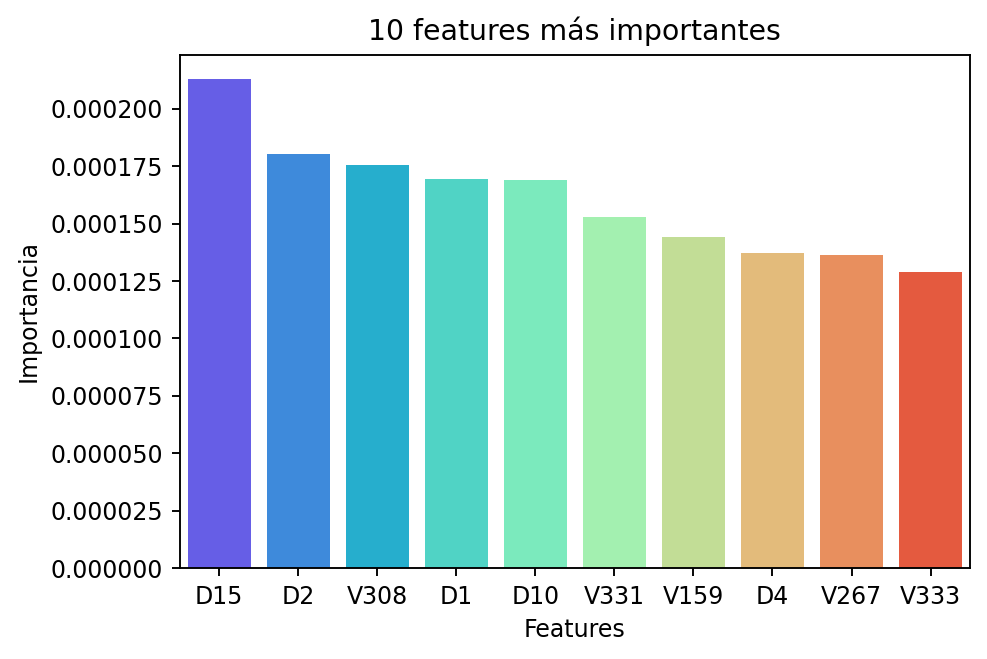

In [33]:
fig, ax = plt.subplots(dpi=170)
sns.barplot(x=df.column, y=df.importance,palette = "rainbow")
ax.set_title('10 features más importantes',fontsize=12)
ax.set_ylabel('Importancia',fontsize=10)
ax.set_xlabel('Features',fontsize=10)
#ax.set_yscale('log')